In [32]:
import torch
import importlib
import callback, my_attn, my_pipeline, utils
importlib.reload(callback)
importlib.reload(my_attn)
importlib.reload(my_pipeline)
importlib.reload(utils)
from my_pipeline import run_with_attn_replacement, MutualAttention
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, DDIMScheduler
from my_attn import prep_unet_attention
from tqdm.notebook import tqdm
from callback import QKVRecordCallback
from utils import load_image, img_to_latents, concat_img 
from callback import ATTN_BLOCKS
from PIL import Image
import matplotlib.pyplot as plt
import os

In [20]:
device = 'cuda'
dtype = torch.float16
model_dir = '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1'
# model_dir = '/home/tom/fshare/models/runwayml/stable-diffusion-v1-5'

pipe = StableDiffusionPipeline.from_pretrained(
    model_dir, safety_checker=None, torch_dtype=dtype)

pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
num_inversion_steps = 999
imgname = 'images/kitten.jpg'
input_img = load_image(
    imgname,
    target_size=(512, 512)
).to(device=device, dtype=dtype)
prompt_inversion = ''

with torch.no_grad():
    pipe.scheduler = DDIMInverseScheduler.from_pretrained(
        '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1', subfolder='scheduler')
    latents = img_to_latents(input_img, pipe.vae)  # VAE latent
    inv_latents, _ = pipe(
        prompt=prompt_inversion,
        guidance_scale=1,
        width=input_img.shape[-1],
        height=input_img.shape[-2],
        output_type='latent',
        return_dict=False,
        num_inference_steps=num_inversion_steps,
        latents=latents,
    )

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

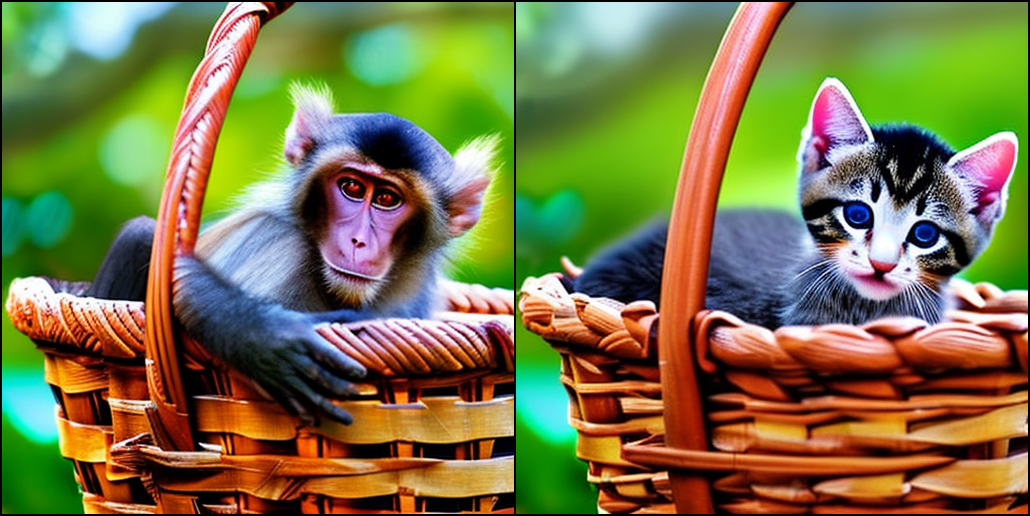

In [18]:
mutual_attn = MutualAttention(pipe)
pipe.scheduler = DDIMScheduler.from_pretrained(
        '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1', subfolder='scheduler')
with torch.no_grad():
    result = mutual_attn(
        replaced_attn_indice=[12],
        replaced_qkv=['q','k','v'],
        end=500,
        prompt='A monkey is sitting in a basket on a branch',
        ref_prompt='A kitten is sitting in a basket on a branch',
        latents=inv_latents,
        ref_latents=inv_latents,
    )
concat_img(list(result))

In [9]:
new_latent = torch.randn_like(inv_latents)

In [31]:
mutual_attn = MutualAttention(pipe)
pipe.scheduler = DDIMScheduler.from_pretrained(
        '/home/tom/fshare/models/Stability-AI/stable-diffusion-2-1', subfolder='scheduler')
replaced_qkv_list = [
    ['none'],
    ['q'],
    ['k'],
    ['v'],
    ['q','k'],
    ['q','v'],
    ['k','v'],
    ['q','k','v'],
]
attn_indice_list = [
    [13],
    [12, 13],
    [11],
    [12, 11],
    [13, 11],
    [12, 13, 11],
]
with torch.no_grad():
    for attn_indice in attn_indice_list:
        for replaced_qkv in replaced_qkv_list:
            result = mutual_attn(
                replaced_attn_indice=attn_indice,
                replaced_qkv=replaced_qkv,
                end=500,
                prompt='A monkey is sitting in a basket on a branch',
                ref_prompt='A kitten is sitting in a basket on a branch',
                latents=new_latent,
                ref_latents=inv_latents,
            )
            img = concat_img(list(result))
            # create folder if not exist
            os.makedirs(f"results/{'_'.join(attn_indice)}", exist_ok=True)
            img.save(f"results/{'_'.join(attn_indice)}/{''.join(replaced_qkv)}.jpg")

  0%|          | 0/50 [00:00<?, ?it/s]